In [1]:
import os
import argparse
import torch
import numpy as np
from models import build_model
from utils import get_dataset, backdoor_train, backdoor_evaluate, validation_per_class
from poisoned_dataset import create_backdoor_data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import time

In [3]:
class args():
    dir = '/home/teun/internship/cluster/results/optimalize'
    datanames = ['mnist', 'emnist', 'fmnist']
    seed = 1
    epsilon = 0.1
    source_label=0
    target_label=1
    epsilons=[0.001, 0.005, 0.010, 0.015, 0.020]
    iid = "True"

In [4]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
device = torch.device('cpu')

data_dir = '/home/teun/internship/sniper-backdoor/data'
results_dir = '/home/teun/internship/cluster/results/mnist'

In [16]:
datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
results_dict = []
for iid in tqdm([True]):
    for dataname in tqdm(datanames.keys(),leave=False):
        for epsilon in tqdm(args.epsilons,leave=False):
            for personalized in [True, False]:
                if personalized:
                    path = os.path.join(
                                    results_dir, 
                                    f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}'
                                    f'_iid_{iid}_finetuned_results.pt'
                                        )
                else:
                    path = path = os.path.join(
                                    results_dir, 
                                    f'{dataname}_{epsilon}_{args.source_label}->{args.target_label}'
                                    f'_iid_{iid}_backdoor_results.pt')
                model = torch.load(path, weights_only=False, map_location=device)

                clean_per_class = model['clean_per_class']
                poisoned_per_class = model['poisoned_per_class']
                asr = float(model['asr'])
                cad = float(model['cad'])

                results_dict.append({'iid': iid, 'dataname': dataname, 'epsilon': epsilon, 'personalized': personalized,
                                    'clean_per_class': clean_per_class, 
                                    'poisoned_per_class': poisoned_per_class, 'asr': asr, 'cad': cad})        

In [17]:
backdoor_df = pd.DataFrame(results_dict)

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_25143/1971837002.py:10: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


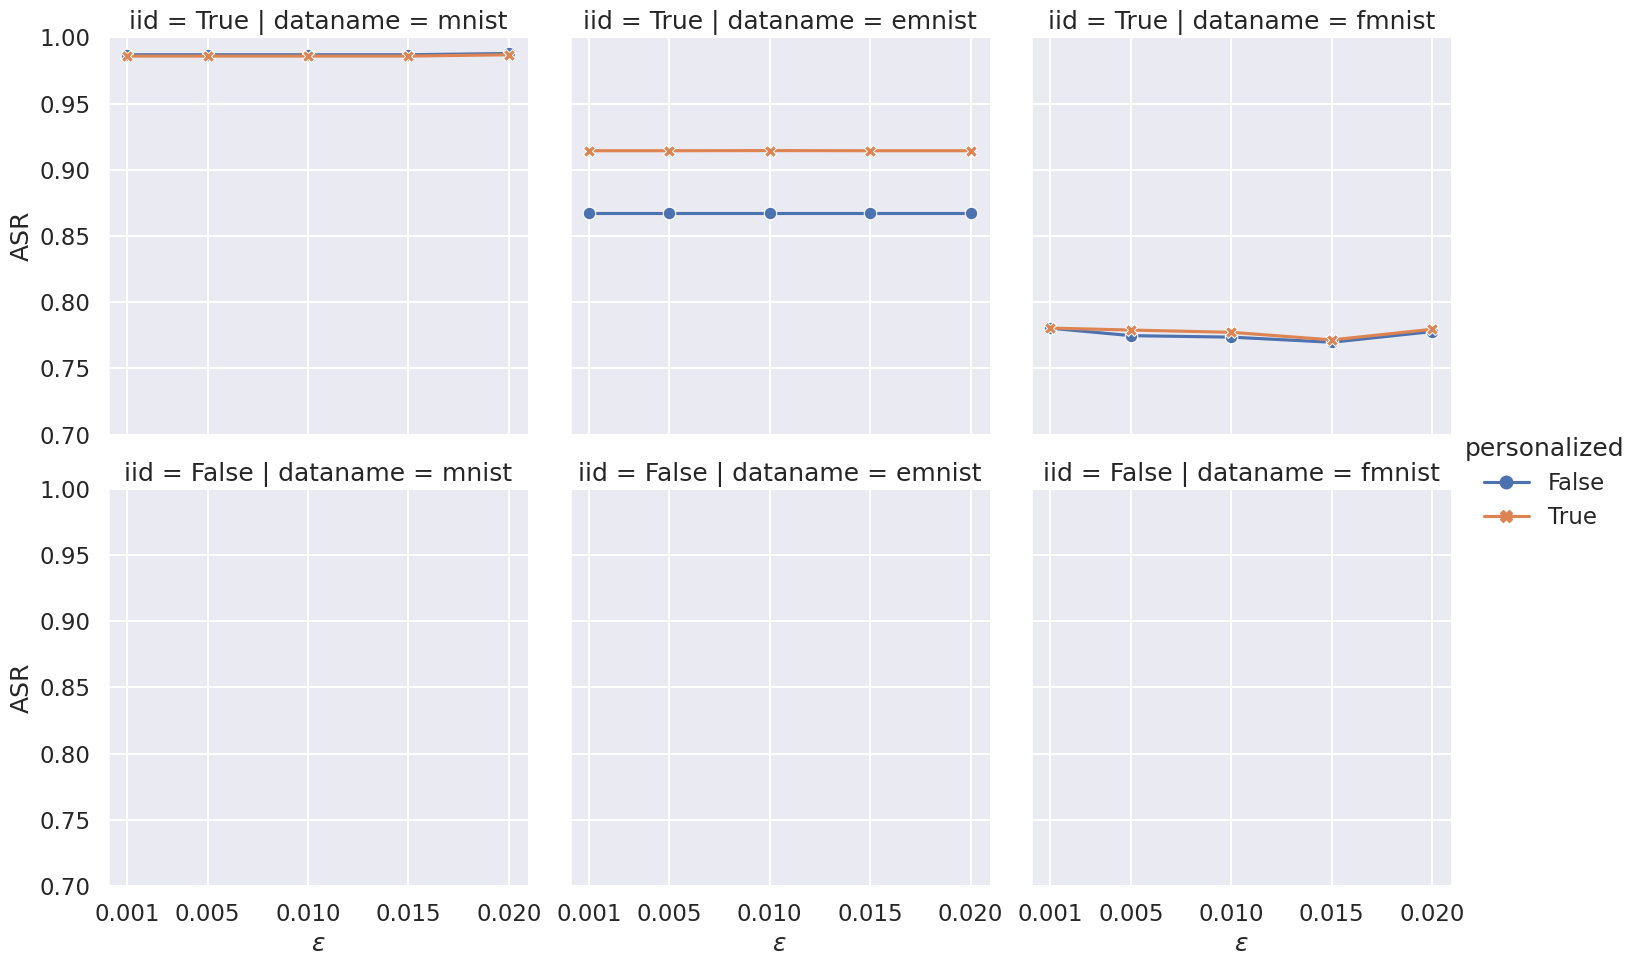

In [19]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='asr', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True, row_order=[True, False])
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.ylim([0.7, 1])
g.set_ylabels('ASR')
g.set_xlabels('$\epsilon$')

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_25143/460529090.py:7: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


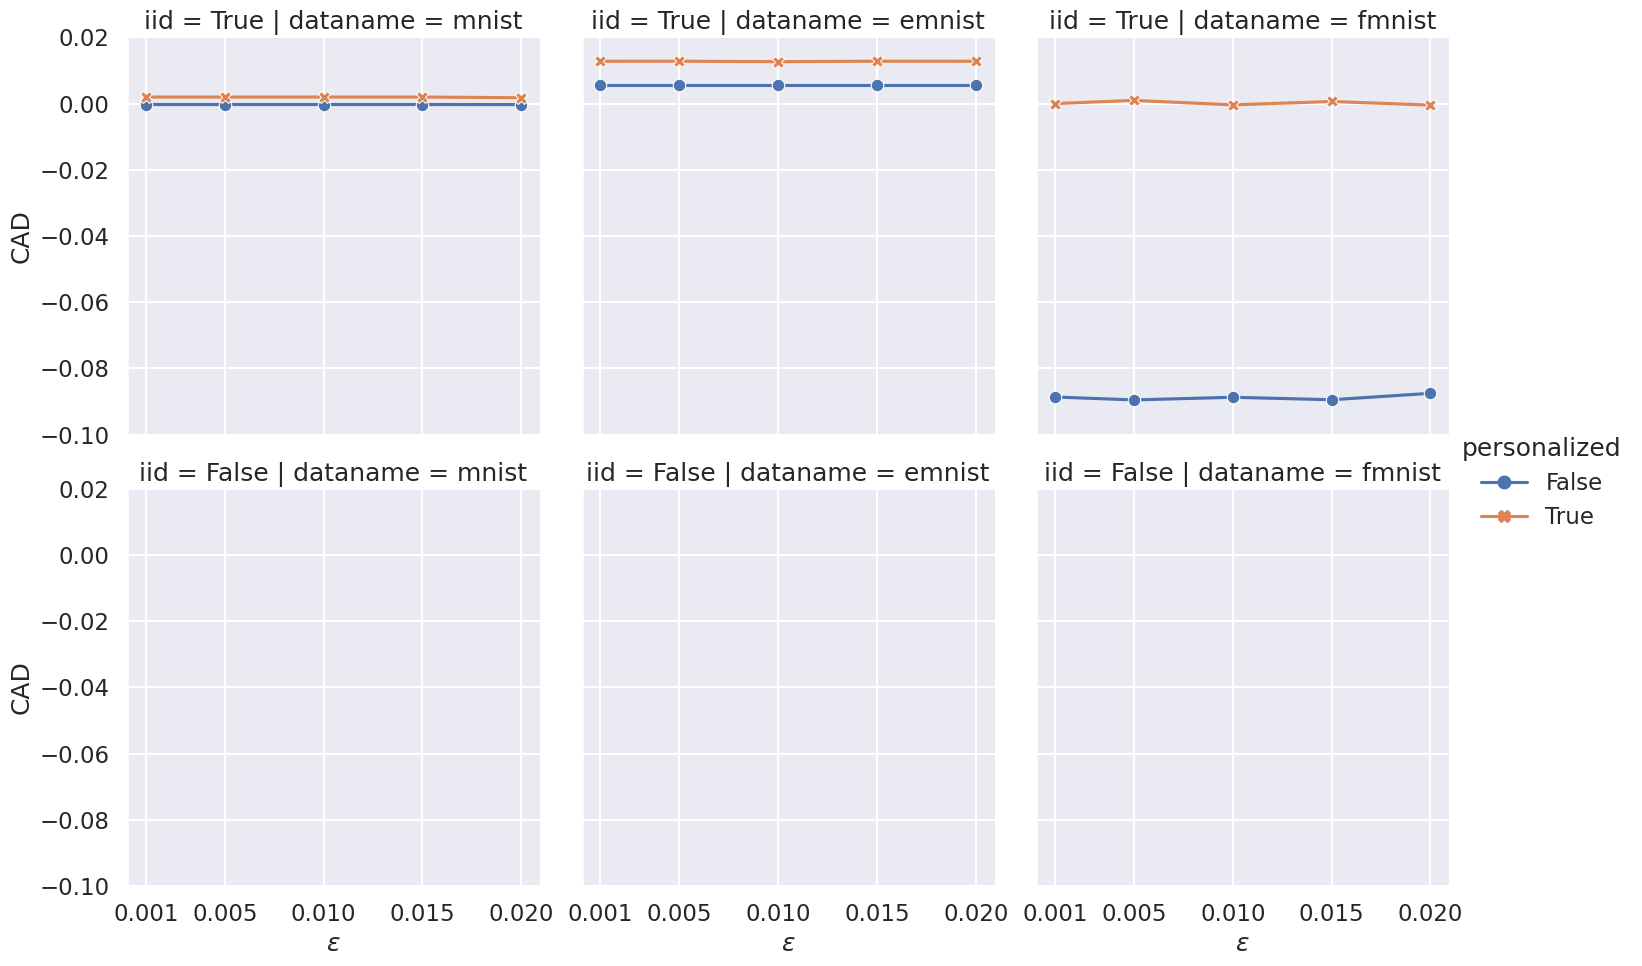

In [31]:
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='cad', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True, row_order=[True, False])
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.yticks(np.linspace(0.02,-0.10,7))
g.set_ylabels('CAD')
g.set_xlabels('$\epsilon$')

In [206]:
datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
results_dict = []
for iid in [True, False]:
    for dataname in datanames.keys():
        for client in tqdm(range(datanames[dataname]),leave=False):

            path = os.path.join(
                results_dir, f'{dataname}_iid_{iid}_client_{client}_results.pt')
            server_model = torch.load(path, weights_only=False, map_location=device)

            train_loss = server_model['train_loss']
            train_acc = server_model['train_acc']
            test_loss = server_model['test_loss']
            test_acc = server_model['test_acc']
            train_epochs = np.arange(len(train_loss))
            test_epochs = np.linspace(1,len(train_epochs)-1,len(test_loss))

            results_dict.append({'iid': iid, 'dataname': dataname, 'client': client, 'mode': 'train',
                                 'loss': train_loss, 'acc': train_acc, 'epochs': train_epochs})
            results_dict.append({'iid': iid, 'dataname': dataname, 'client': client, 'mode': 'test',
                                 'loss': test_loss, 'acc': test_acc, 'epochs': test_epochs})
            
        path = os.path.join(
            results_dir, f'{dataname}_iid_{iid}_server_results.pt')
        server_model = torch.load(path, weights_only=False, map_location=device)
        print(path)

        test_loss = server_model['loss']
        test_acc = server_model['acc']

        results_dict.append({'iid': iid, 'dataname': dataname, 'client': None, 'mode': 'test',
                             'loss': test_loss, 'acc': test_acc, 'epochs': np.arange(len(test_loss))})
        

/home/teun/internship/cluster/results/optimalize/mnist_iid_True_server_results.pt


/home/teun/internship/cluster/results/optimalize/emnist_iid_True_server_results.pt


/home/teun/internship/cluster/results/optimalize/fmnist_iid_True_server_results.pt


/home/teun/internship/cluster/results/optimalize/mnist_iid_False_server_results.pt


/home/teun/internship/cluster/results/optimalize/emnist_iid_False_server_results.pt


/home/teun/internship/cluster/results/optimalize/fmnist_iid_False_server_results.pt


In [207]:
df = pd.DataFrame(results_dict)
df = df.explode(['loss', 'acc', 'epochs'], ignore_index=True)
df['loss'] = df['loss'].astype(float)

In [208]:
train = df[df['mode']=='train']
server = df[(df['client'].isna()) & (df['mode']=='test')]

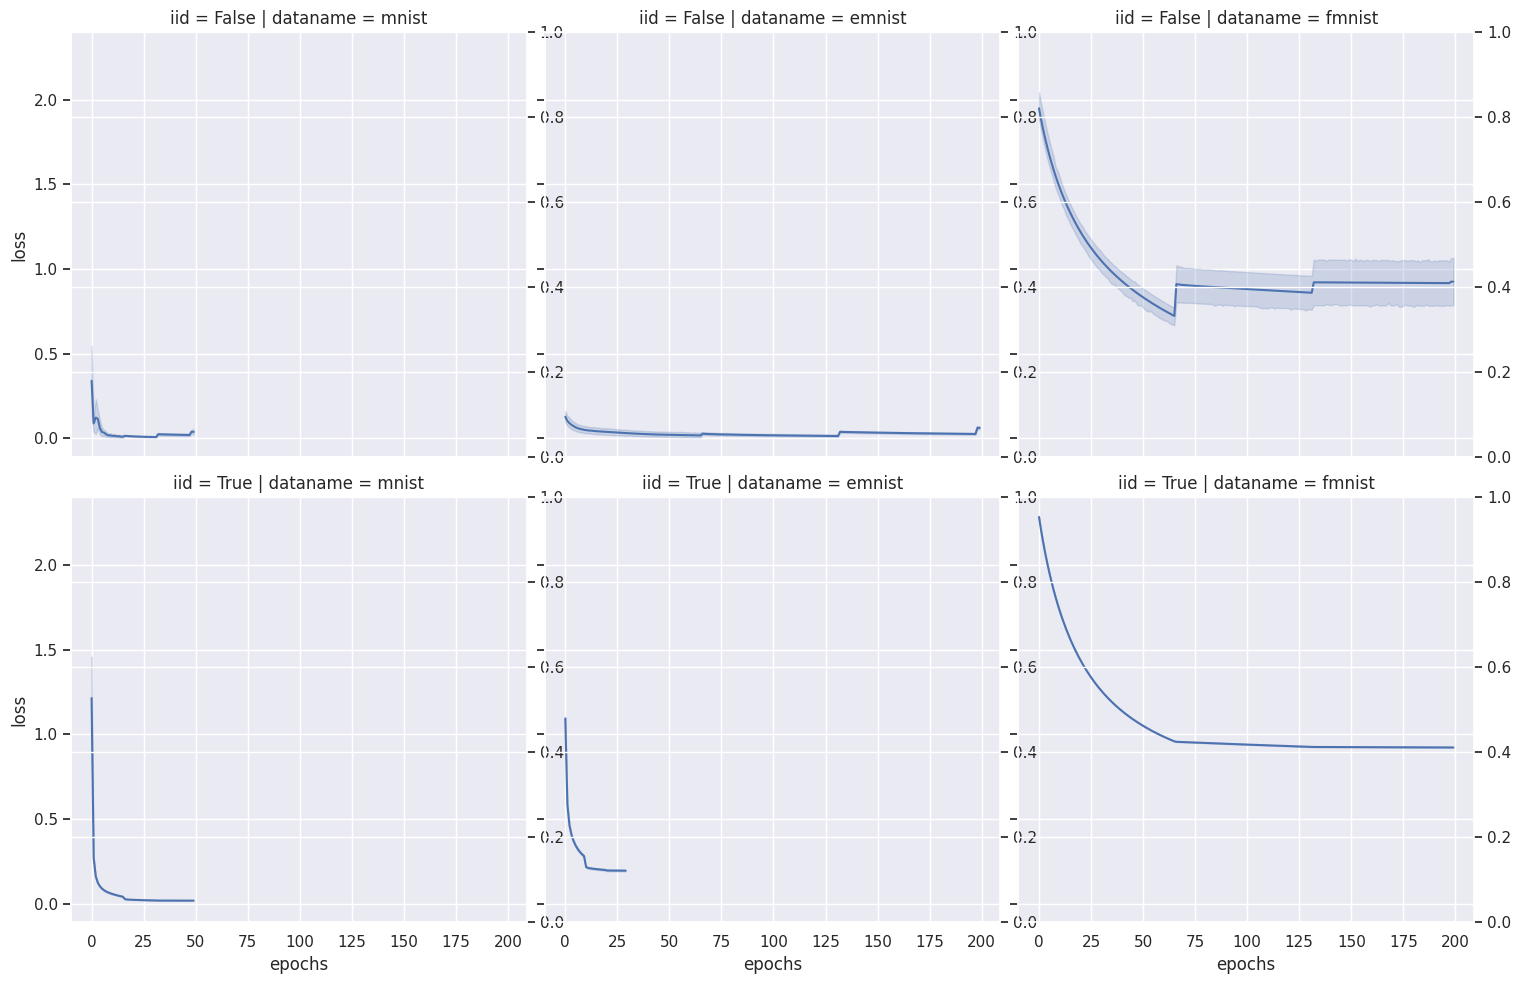

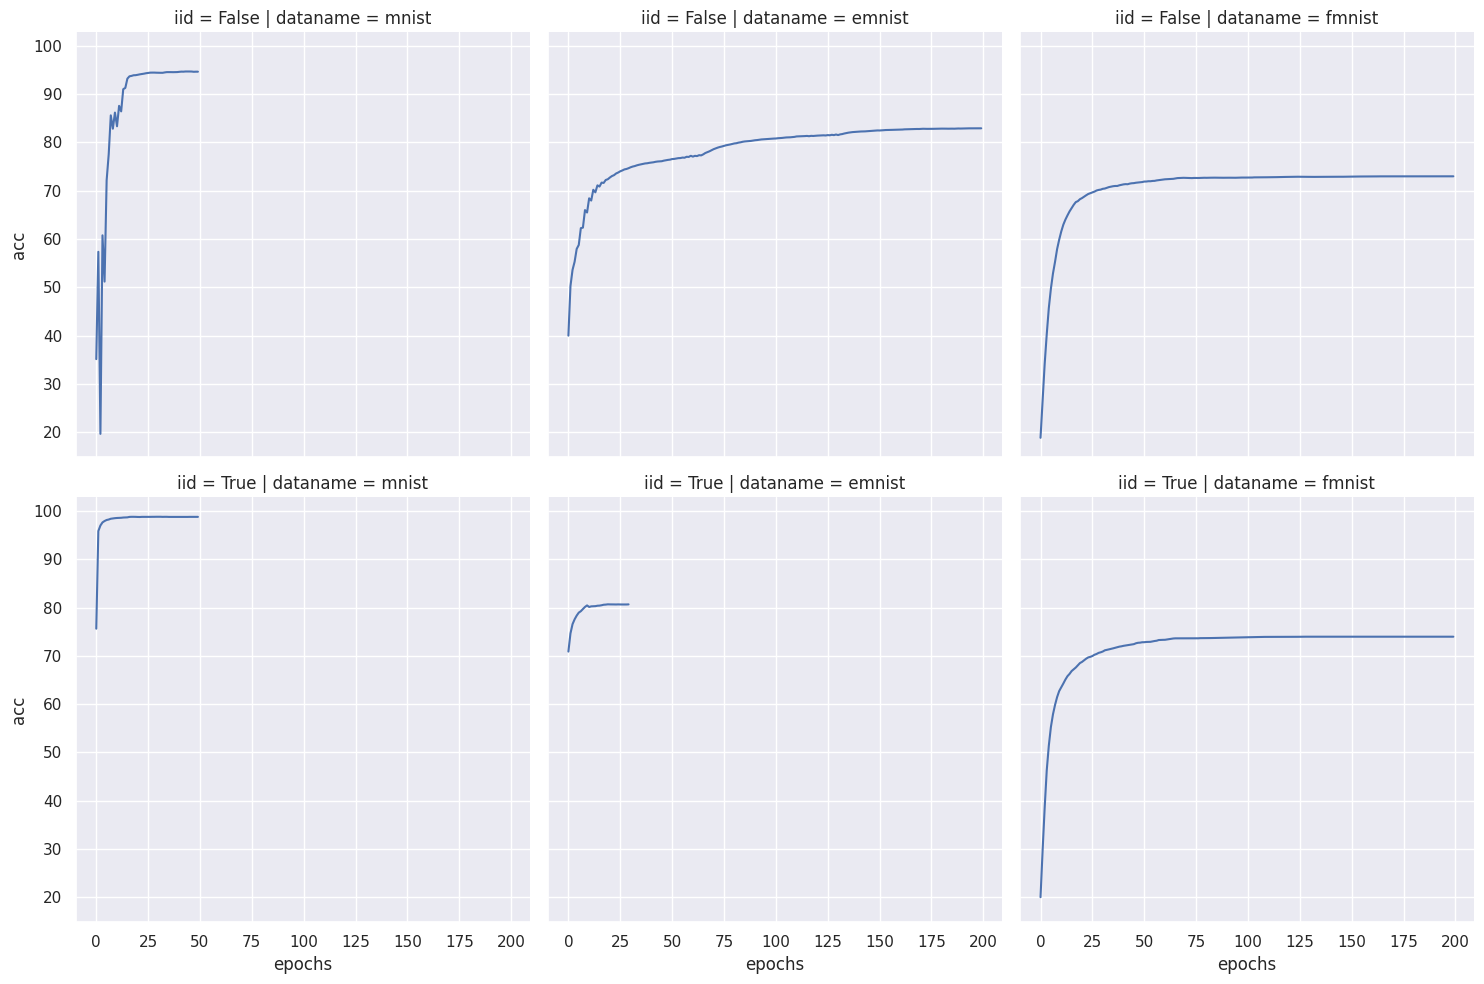

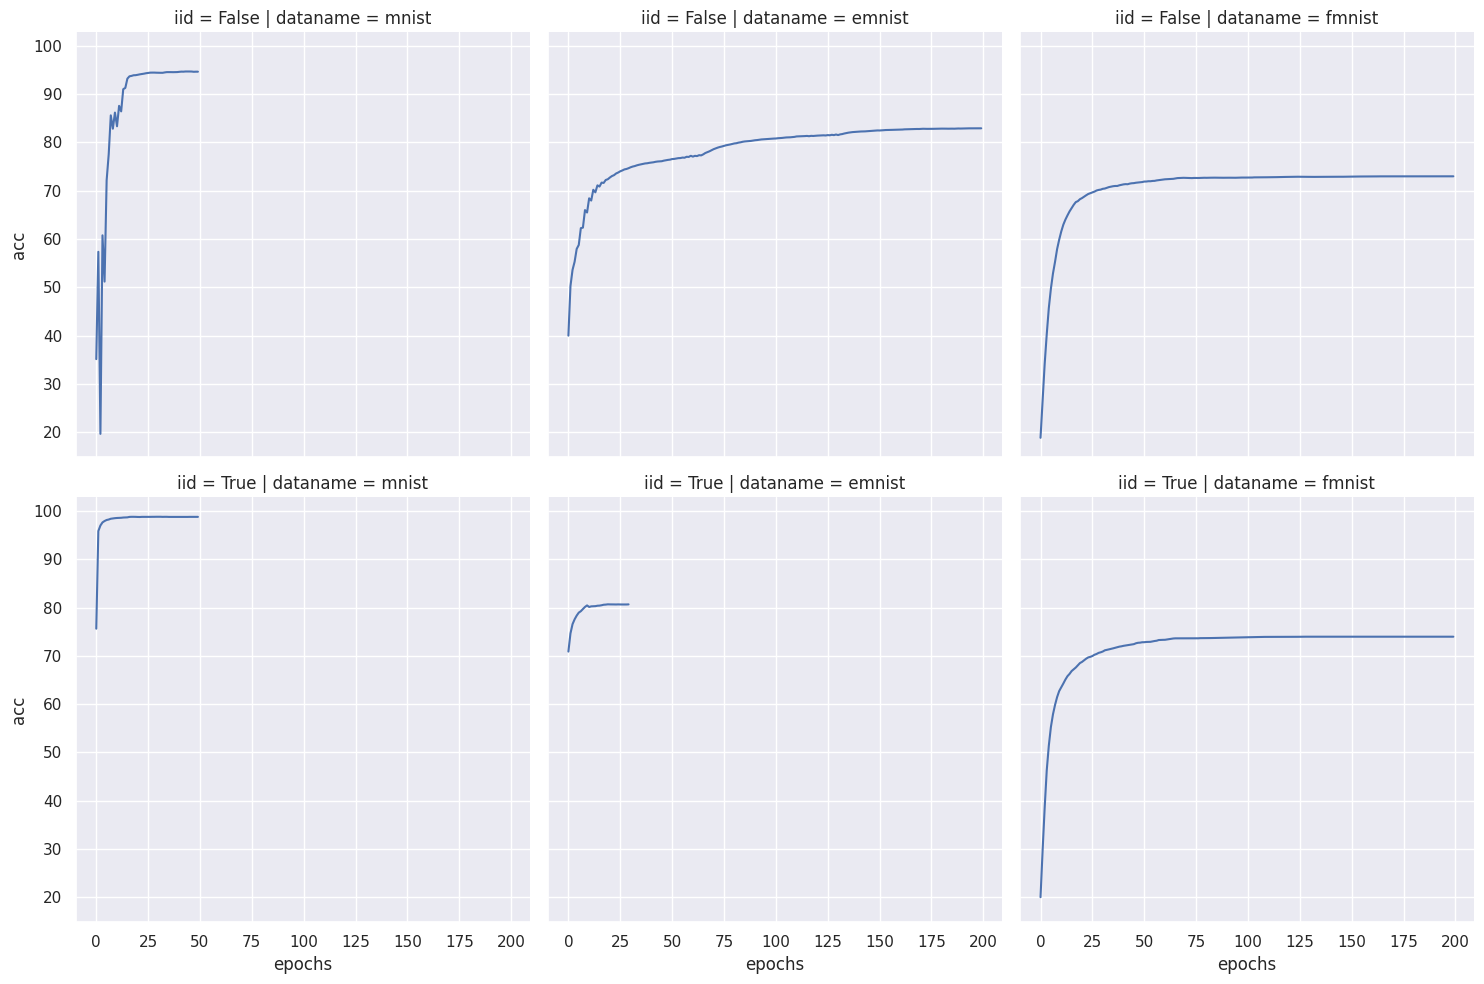

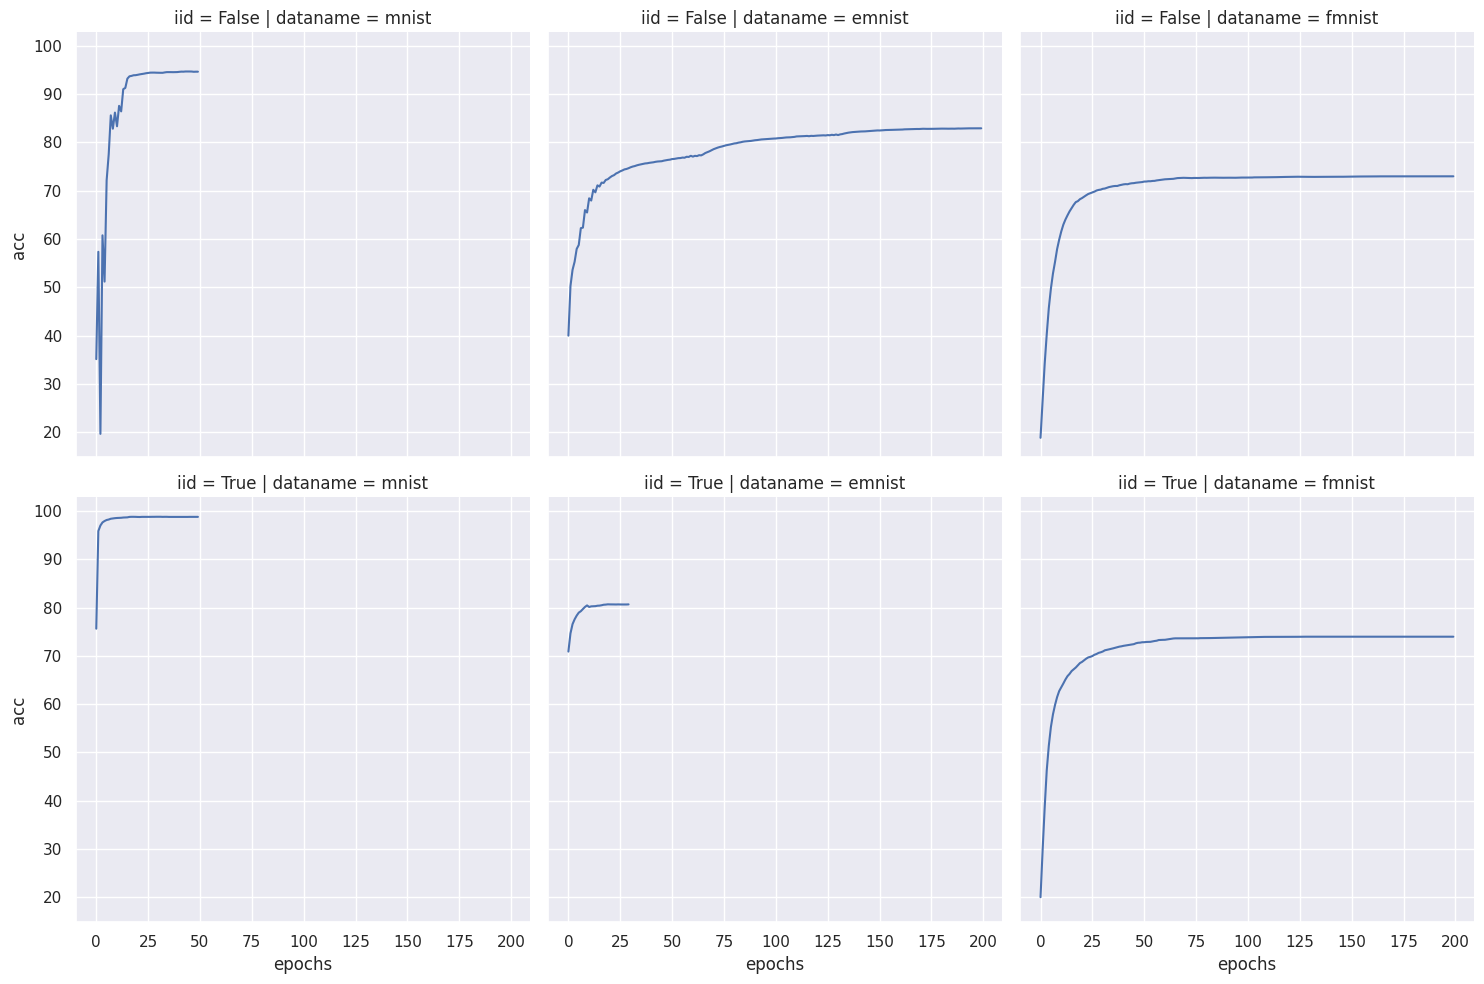

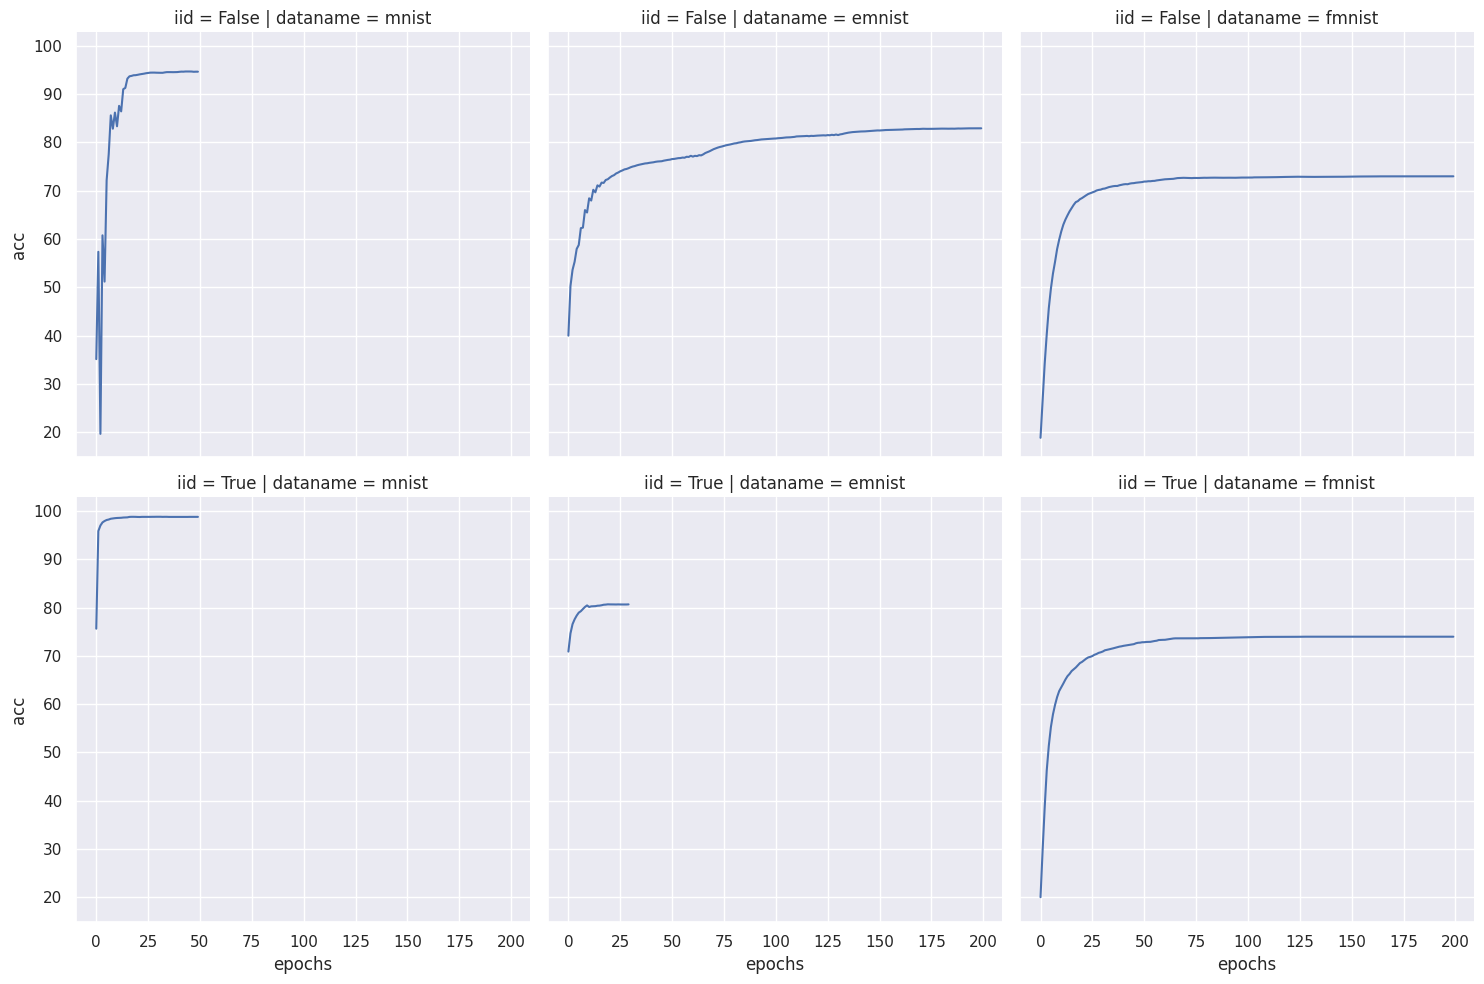

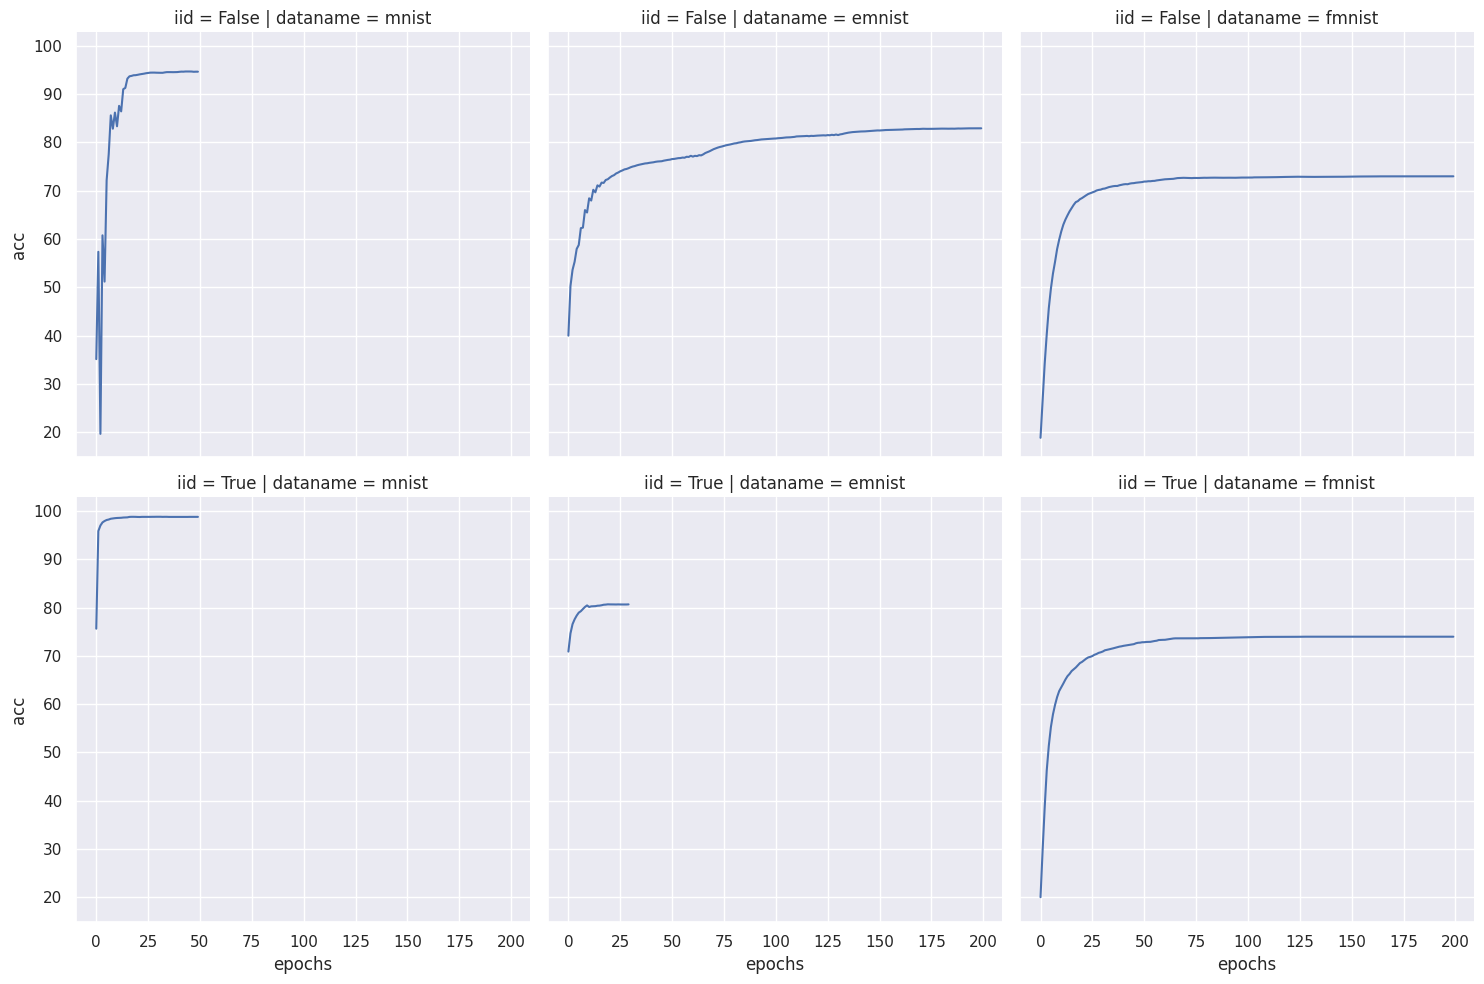

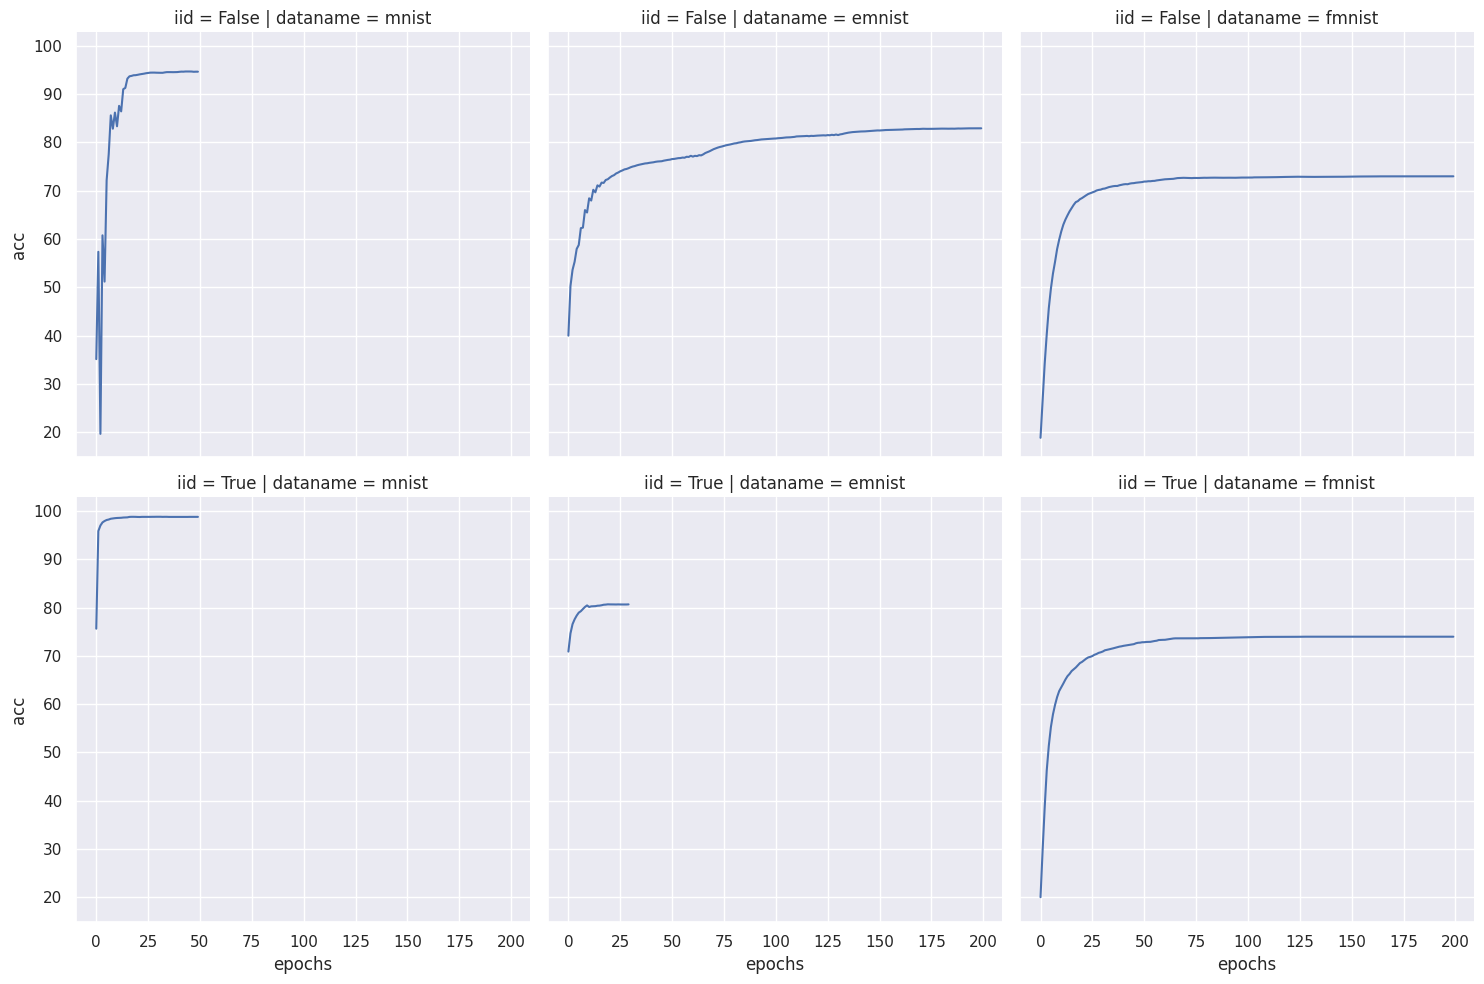

In [210]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('notebook')
g = sns.relplot(
    data=train,
    x='epochs', y='loss', col='dataname', row='iid', 
    kind='line'
)
for (dataname, iid), ax in g.axes_dict.items():  
    ax1 = ax.twinx()
    sns.relplot(
    data=server,
    x='epochs', y='acc', col='dataname',  row='iid', 
    kind='line'
)
# sns.relplot(
#     data=server,
#     x='epochs', y='acc', col='dataname',  row='iid', 
#     kind='line'
# )
# for (iid, dataname), ax in g.axes_dict.items():
#     data=test[(test['dataname']==dataname) & (test['iid']==iid)]
#     print(data.head(10))
#     sns.lineplot(data=data, x='epochs', y='loss', hue='client', estimator=None, ax=ax, color='.7')
# plt.ylim((0,10))

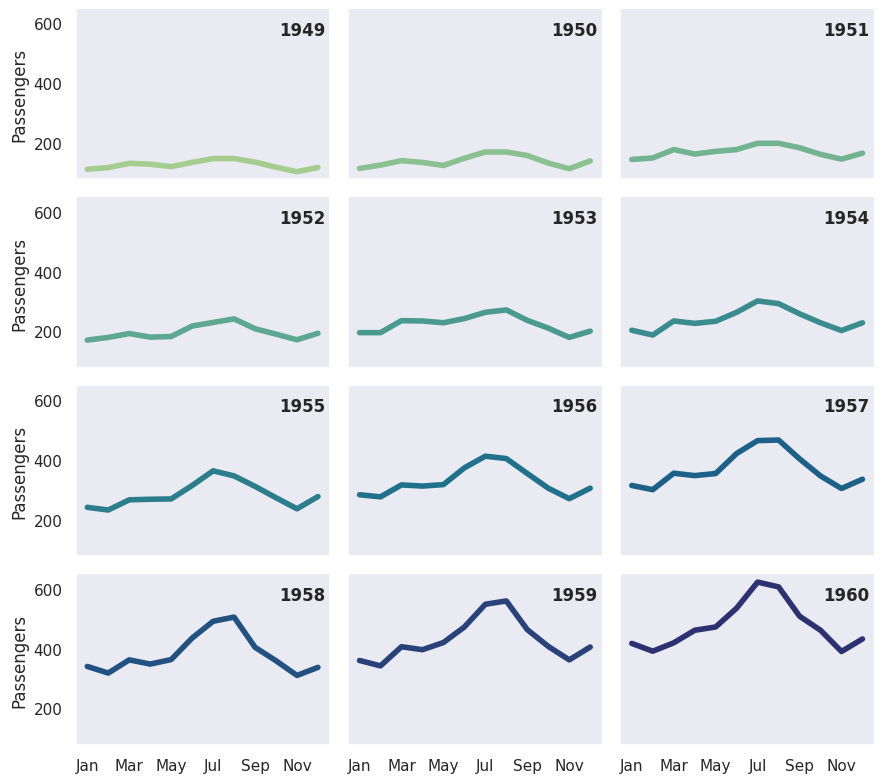

In [61]:
import seaborn as sns

sns.set_theme(style="dark")
flights = sns.load_dataset("flights")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=flights,
    x="month", y="passengers", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=flights, x="month", y="passengers", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

In [ ]:
    data=flights,
    x="month", y="passengers", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=flights, x="month", y="passengers", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

[91.94, 96.09, 97.15, 97.52, 97.56, 97.82, 97.93, 98.09, 98.68, 98.75, 98.75, 98.77, 98.78, 98.77, 98.76, 98.76, 98.78, 98.77, 98.78, 98.78, 98.78, 98.78, 98.78, 98.78, 98.79]
[tensor(0.2598), tensor(0.1248), tensor(0.0915), tensor(0.0801), tensor(0.0744), tensor(0.0689), tensor(0.0643), tensor(0.0594), tensor(0.0387), tensor(0.0373), tensor(0.0370), tensor(0.0368), tensor(0.0367), tensor(0.0367), tensor(0.0367), tensor(0.0367), tensor(0.0366), tensor(0.0365), tensor(0.0365), tensor(0.0365), tensor(0.0364), tensor(0.0364), tensor(0.0364), tensor(0.0364), tensor(0.0365)]
[93.24, 95.91, 97.03, 97.6, 97.78, 97.81, 97.99, 97.9, 98.66, 98.73, 98.73, 98.73, 98.74, 98.77, 98.76, 98.77, 98.75, 98.75, 98.75, 98.76, 98.76, 98.76, 98.76, 98.77, 98.79]
[tensor(0.2421), tensor(0.1384), tensor(0.1054), tensor(0.0835), tensor(0.0795), tensor(0.0762), tensor(0.0712), tensor(0.0714), tensor(0.0416), tensor(0.0400), tensor(0.0395), tensor(0.0393), tensor(0.0392), tensor(0.0391), tensor(0.0391), tensor(0

<Figure size 640x480 with 0 Axes>

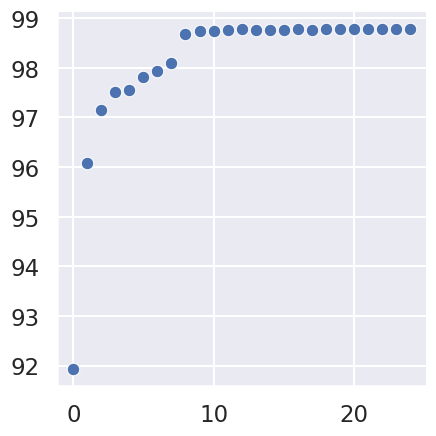

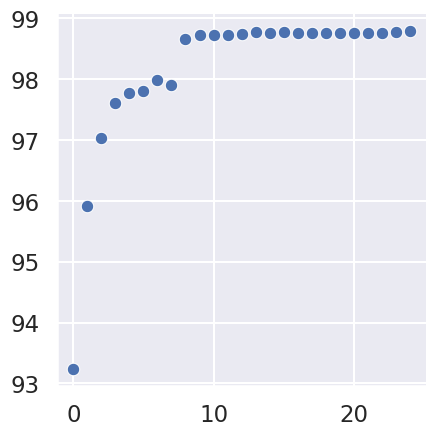

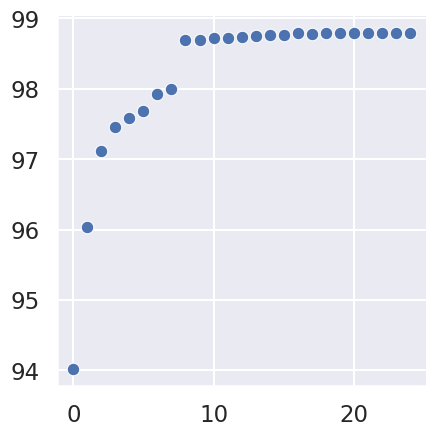

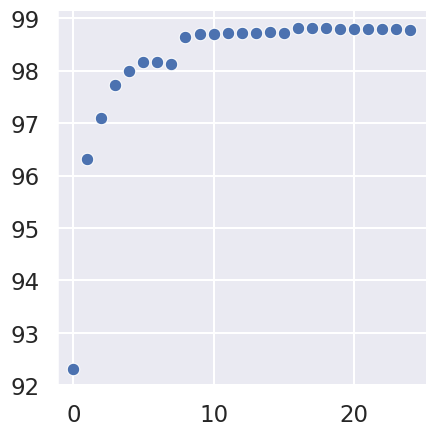

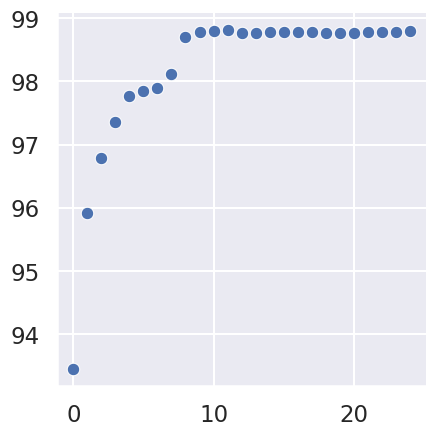

In [101]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
for iid in [True]:
    for dataname in datanames:
        plt.figure()
        for client in range(datanames[dataname]):
            temp_df = df[(df['client']==client) & (df['iid']==iid) & (df['dataname']==dataname)]
            temp_df.head()
            accs = list(temp_df['test_acc'])[0]
            losses = list(temp_df['test_loss'])[0]
            print(accs)
            print(losses)
            sns.relplot(x=np.arange(len(accs)), y=accs)
        plt.show()  
        break  
        

In [113]:
len(temp_df['train_acc'].to_list()[0])

50

In [114]:
expanded = temp_df.explode(['train_acc','train_loss'])

In [115]:
expanded

,iid,dataname,client,train_loss,train_acc,test_loss,test_acc,epochs
4,True,mnist,4.0,1.021822,84.732759,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.26784,92.37069,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.158963,95.241379,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.12147,96.275862,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.100218,96.956897,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.08681,97.439655,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.077406,97.793103,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.071008,98.008621,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.065524,98.12931,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50
4,True,mnist,4.0,0.060734,98.181034,"[tensor(0.2313), tensor(0.1357), tensor(0.1059...","[93.45, 95.91, 96.79, 97.36, 97.77, 97.84, 97....",50


In [76]:
test = iid_mnist_df.apply(pd.Series.explode)

ValueError: cannot reindex on an axis with duplicate labels